# Hierarquical Models


A la hora de analizar datos es importante tener en cuenta qué estructura presentan. Por
ejemplo, en el caso de hacer mediciones de un fenómeno natural de diferentes condiciones
experimentales o equipos de investigación, tomar a todas estas mediciones en pie de igualdad y analizarlas como un todo es ignorar las diferencias de su procedencia. Un caso clásico en la literatura que contempla la estructura de los datos es el estudio de tratamientos de tumores de rata en laboratiorios por Gelman, _et_al_. En ese estudio se determina la probabilidad de que un tratamiento oncologico funcione, los resultados de cada ensayo variaban segun diferencias
entre las ratas y condiciones experimentales de cada labiratorio. Por lo tanto, procesar la
información de todos los datos como un solo conjunto no hacıa uso de la información estas variaciones. Una manera de incorporarlas consiste en analizar independientemente la probabilidad de eficacia del tratamiento en cada laboratorio j indivdualmente, que dependeraád e ciertos par ́ametros $\theta_{j}$. A su vez, se puede construir una capa superior en el
modelado que vincule a los $\theta_{j}$ entre sí, esta capa define una probabilidad para cada uno
de ellos y está caracterizada por hiperparámetros $\phi$. Es decir que los parámetros $\theta_{j}$ que
definen las probabilidades en cada laboratorio vienen de una distribución común. De esta
forma se modela un mismo fenómeno contemplando la variabilidad en cada realziación del
experimento. 

La dependencia estadística de las variables es la siguiente:

$$
P(\phi) \\
P(\theta_{i}|\phi)\\
P(D_{i}|\theta_{i})
$$

Y se exhibe en el siguiente diagrama
![](../bin/figs/diag_model.png)


In [23]:
# IMPORTS 
from numpy import *
from scipy.stats import binom,beta
from scipy.stats import binom
from scipy.stats import betabinom
from scipy.special import loggamma
from cmdstanpy import CmdStanModel, cmdstan_path
import matplotlib.pyplot as plt


## Modelo Binomial

Consideremos un conjunto de datos $D = \{ (n_{i},N_{i}) \}_{i=1}^{M}$ que resultan de registrar el número de curados $n_{i}$ que salieron de tratar $N_{i}$ ratones en $M$ laboratorios. Un primer modelo que podemos hacer es considerar que todos los resultados provienen de una misma distribución como:

$$
 P(D|\theta) \propto \prod_{i}^{M_{i}} \theta^{n_{i}} \left(1-\theta\right)^{N_{i}-n_{i}} = \theta^{\sum_{i} n_{i}} \left(1-\theta\right)^{\sum_{i} (N_{i}-n_{i}) } 
$$
donde $\theta$ es un parátemtro que representa la probabilidad de que el tratamiento funcione.

La distribución posterior de $\theta$, $P(\theta|D)$, se escribe como:

$$
P(\theta|D) \propto \theta^{\sum_{i} n_{i}} \left(1-\theta\right)^{\sum_{i} (N_{i}-n_{i}) } \times P(\theta)
$$
donde $P(\theta)$ es nuestra prior sobre $\theta$. Si tomamos una prior sobre $\theta$ como una distribución de la forma $P(\theta) \propto 
\theta^{\alpha_{0}} (1-\theta)^{\beta_{0}}$, la distribución resultante para $P(\theta|D)$ corresponderá a una distribución $Beta(\alpha,\beta)$, con $\alpha = \sum_{i} n_{i} + \alpha_{0} +1$ y $\beta = \sum_{i} (N_{i}-n_{i})+ \beta_{0} +1$

En lo que sigue consideraremos $P(\theta) \propto 1$, es decir $\alpha_{0} = \beta_{0} = 1$

## Datos

In [24]:
Ni = array([40, 26, 56, 54, 29, 29, 32, 28, 44, 58, 44, 56, 27, 23, 23, 53, 57,
       58, 22, 32, 53, 36, 56, 36, 21, 22, 24, 50, 38, 24])

ni = array([ 2,  7, 15,  7,  6,  3,  6,  4,  0, 12, 36,  1,  1,  6,  7, 15, 10,
       11,  4, 11,  9, 18, 28, 14,  3,  5,  3, 33,  8,  2])


In [25]:
betas_samples = beta.rvs(a = sum(ni)+1,b = sum(Ni-ni)+1,size = 4000)

### Plots


(0.2, 0.3)

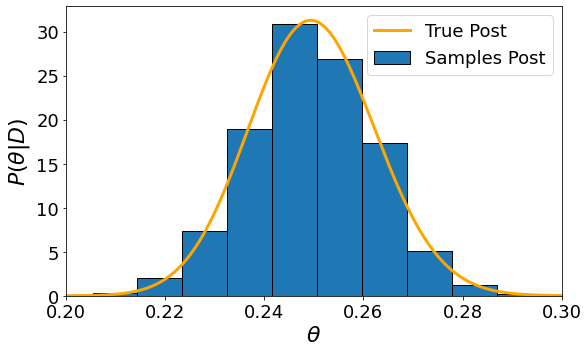

In [26]:
true_post = lambda x: beta.pdf(x,sum(ni)+1,sum(Ni-ni)+1)
x = linspace(0,1,1000)

fig = figure(figsize = (8,5))
plot(x,true_post(x),color = "orange", lw = 3,label = "True Post")
hist(betas_samples,density = True,edgecolor = "k" ,label = "Samples Post")
plt.ylabel(r"$P(\theta|D)$",fontsize = 22)
plt.xlabel(r"$\theta$",fontsize = 22)
tick_params(axis='both', which='major', labelsize=18)
legend(fontsize = 18)
tight_layout()
xlim(0.2,0.3)

## Model Checking

En la construcción del modelo consideramos que todos los datos provienen de la misma distribución, una manera de evaluar si efectivamente el modelo representa al conjunto de datos "correctamente" es hacer réplicas de los mismos y comprararlos con los originales. Es decir samplear la distribución:

$$
P(n_{i}^{\text{rep}}|D,N_{i}) = \int_{0}^{1} P(n_{i}^{\text{rep}}|N_{i},\theta) P(\theta|D)\, d\theta \sim BetaBinom(n_{i}^{\text{rep}}|N_{i},\alpha,\beta)
$$
con $\alpha = \sum_{i} n_{i}+1$ y $\beta = \sum_{i} (N_{i}-n_{i}) +1$.

La distribución para las réplicas en este modelo la tenemos calculada analíticamente pero e genneral no será posible. Lo bueno es que con STAN podemos calcular la integral que define a la distribución tomando muestras de la posterior de $\theta$ y luego usarlarlas para samplear $n_{i}^{rep}$. 


In [33]:
 sum(Ni-ni)+1

865

In [35]:
nrep_samples = []
a = sum(ni)+1
b = sum(Ni-ni)+1
for NN,nn in zip(Ni,ni):
    nrep_samples.append(betabinom.rvs(NN, a ,b,size = 4000))

### Posterior predictivas de los datos

5.987 4.22010947725293


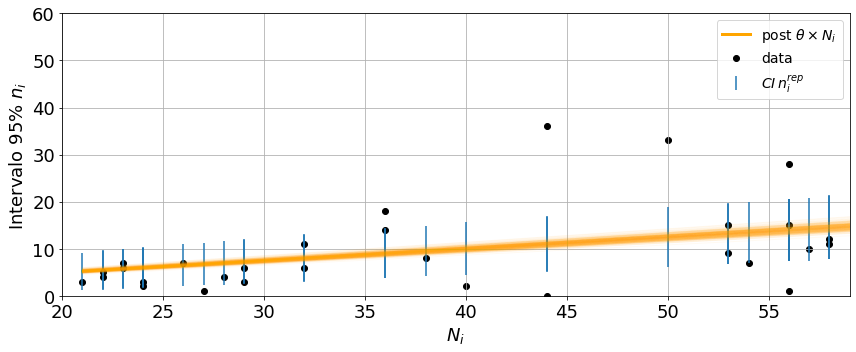

In [37]:

fig = figure(figsize = ( 12,5))
scatter(Ni,ni,color ="k",label = "data")
x = linspace(min(Ni),60,1000)
for t in betas_samples[::20]:
    plot(x,x*t,color = "orange", lw = 1,alpha = 0.05)
axvline(1000,color = "orange", lw = 3,label = r"post $\theta \times N_{i}$")

for i in range(len(Ni)):
    ## pooled
    mean_ni_rep = mean(nrep_samples[i])
    std_ni_rep = std(nrep_samples[i])
    errorbar(Ni[i],mean_ni_rep,yerr=2*std_ni_rep,fmt = "none",color = "#1f77b4")
    
errorbar(Ni[i],mean_ni_rep,yerr=2*std_ni_rep,fmt = "none",color = "#1f77b4",label = "$CI\,n_{i}^{rep} $")
print(mean_ni_rep,2*std_ni_rep)

legend(fontsize = 14)
xlim(min(Ni)-1,max(Ni)+1)

plt.xlabel(r"$N_{i}$",fontsize = 18)
plt.ylabel(r"Intervalo 95% $n_{i}$",fontsize = 18)
tick_params(axis='both', which='major', labelsize=18)
ylim(0,60)
tight_layout()
grid()
    

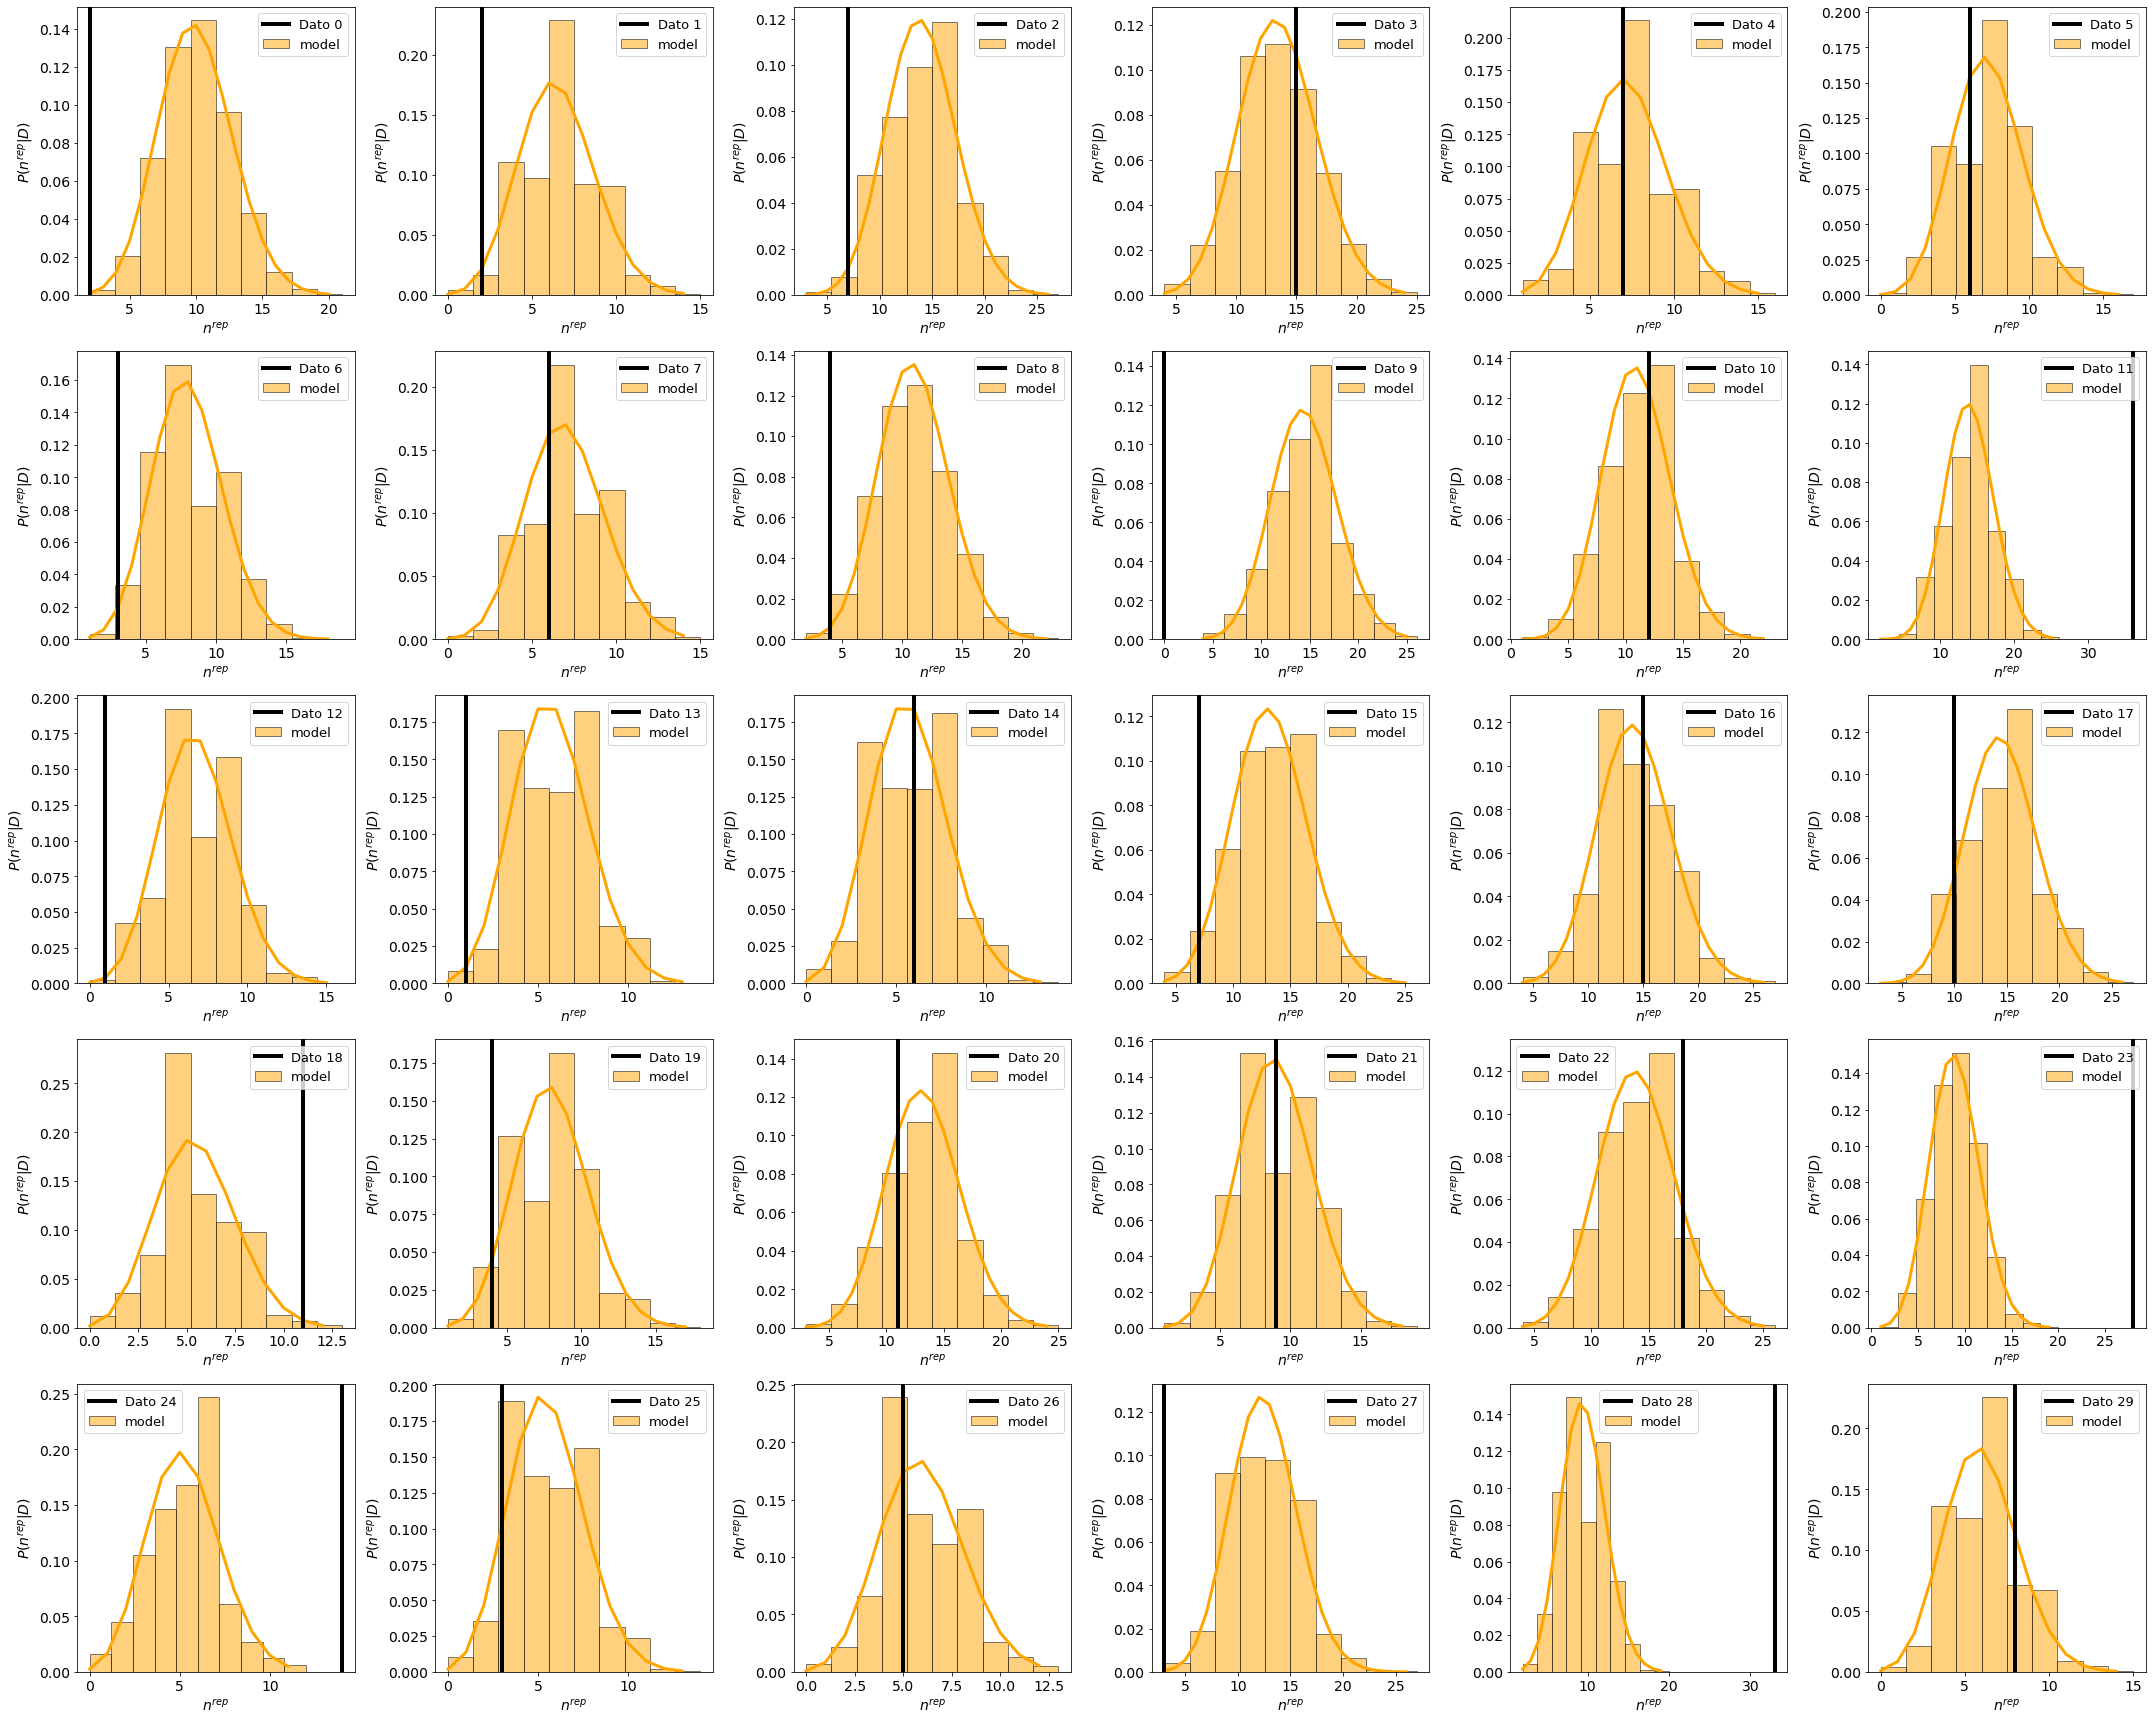

In [38]:
alpha = sum(ni) + 1
beta = sum(Ni)-alpha+ 1

fig = plt.figure(figsize = (30,24))
for i in arange(0,30):
    plt.subplot(5,6,i+1)
    
    ### hist reps
    plt.hist(nrep_samples[i],density = True,edgecolor = "k" ,label = "model",color ="orange",alpha = 0.5)
    
    ## true posterior predictive
    ns_rep = arange(min(nrep_samples[i]),max(nrep_samples[i]),1)
    pred_true = lambda x: betabinom.pmf(x,Ni[i],alpha,beta)
    plt.plot(ns_rep,pred_true(ns_rep), lw = 3, color = "orange")
         
    ## pars plot
    plt.ylabel(r"$P(n^{rep}|D)$",fontsize = 14)
    plt.xlabel(r"$n^{rep}$",fontsize = 14)
    plt.axvline(ni[i-1],color = "k", lw = 4,label = "Dato {}".format(i))
    plt.tick_params(axis='both', which='major', labselsize=14)
    plt.legend(fontsize = 13)
    plt.tight_layout()


## Observaciones

Del gráficos vemos que hay varios datos que son muy poco verosimiles bajo los ojos del modelo. 

# Modelo Jerárquico


Podemos intentar expandir el modelo que tenemos para poder explicar mejor los resultados obenidos por cada laboratorio. Para eso  introducimos una capa más en el modelado que corresponde a poner una prior paramétrica en $\theta$, es decir:

$$
P(n_{i}|\theta_{i},N_{i}) \sim Bin(\theta_{i})\\
P(\theta_{i}|\alpha,\beta) \sim Beta(\alpha,\beta)\\
P(\alpha,\beta)
$$
donde $P(\alpha,\beta)$ es la prior sobre los hyperparametros $\alpha$ y $\beta$ que será informativa o no según el caso. 

Si llamamos a los hyperparámetros $\phi$ y al conjunto de parámetros $\mathbf{\theta}$, el problema bayesiano a resolver se resumen en obtener la posterior:

$$
P(\phi,\mathbf{\theta}|\{n_{i},N_{i}\}) \propto P\left(\{n_{i}\}|\{N_{i}\},\mathbf{\theta}\right) P(\mathbf{\theta}|\phi) P(\phi)
$$

Luego, en caso de querer ver la posterior de una "población" o medición indiividual $i$ podemoas hacerlo como:
$$
P(\theta_{i}|D,\phi) = \frac{P(\theta_{i},\phi|D)}{P(\phi|D)}
$$

Donde $P(\phi|D)$ es la marginalización sobre todos los parámetros $\theta_{i}$:
$$
P(\phi|\{n_{i},N_{i}\}) \propto \int d\theta_{1} \dots \int d\theta_{M} P\left(\{n_{i}\}|\{N_{i}\},\mathbf{\theta}\right) P(\mathbf{\theta}|\phi) P(\phi)\\
$$


En nuestro caso entonces vamos a tener 30 datos $\{n_{i},N_{i}\}$ distribuidos como binomiales con su respectivo $\theta_{i}$ que van a estar vinculados através de $\phi = (\alpha,\beta)$.

Haciendo la cuenta resulta que:
$$
P(\phi|\{n_{i},N_{i}\}) \propto P(\alpha,\beta) \prod_{i=1}^{N}\frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}\frac{\Gamma(\alpha+n_{j})\Gamma(\beta + N_{j}-n_{j})}{\Gamma(\alpha + \beta + n_{j})}
$$
Otra cantidad de interés es la posterior predictiva de $\theta$:

$$
P(\tilde{\theta}|D) = \int P(\tilde{\theta}|\phi)P(\phi|D) d\phi
$$

Esta cantidad nos dice cual es la probabilidad de un nuevo $\theta$ considerando todos los datos.

### Stan H.Model

In [3]:
hier_model = CmdStanModel(stan_file='stan_files/hier_model.stan')


INFO:cmdstanpy:compiling stan program, exe file: /home/martin/DOC/Bayesian_ML_Workshop_2023/Bayesian_lectures/Notebooks/stan_files/hier_model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/martin/DOC/Bayesian_ML_Workshop_2023/Bayesian_lectures/Notebooks/stan_files/hier_model


In [9]:
hier_data = {"M": len(Ni),"ni": ni,"Ni": Ni }
post_hier = hier_model.sample(data=hier_data,seed = 42);
post_hier.diagnose()
hier_samples = post_hier.draws_pd()

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:Processing csv files: /tmp/tmpieooz74z/hier_model-202306211038-1-nwj1jmg3.csv, /tmp/tmpieooz74z/hier_model-202306211038-2-cdt8a2rf.csv, /tmp/tmpieooz74z/hier_model-202306211038-3-fdv3abs9.csv, /tmp/tmpieooz74z/hier_model-202306211038-4-rcyujepq.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


In [10]:
## Veamos como de qué hay muestras
print(hier_samples.keys()[7:])

Index(['theta[1]', 'theta[2]', 'theta[3]', 'theta[4]', 'theta[5]', 'theta[6]',
       'theta[7]', 'theta[8]', 'theta[9]', 'theta[10]', 'theta[11]',
       'theta[12]', 'theta[13]', 'theta[14]', 'theta[15]', 'theta[16]',
       'theta[17]', 'theta[18]', 'theta[19]', 'theta[20]', 'theta[21]',
       'theta[22]', 'theta[23]', 'theta[24]', 'theta[25]', 'theta[26]',
       'theta[27]', 'theta[28]', 'theta[29]', 'theta[30]', 'alpha', 'beta',
       'phi', 'kappa', 'theta_rep', 'ni_rep[1]', 'ni_rep[2]', 'ni_rep[3]',
       'ni_rep[4]', 'ni_rep[5]', 'ni_rep[6]', 'ni_rep[7]', 'ni_rep[8]',
       'ni_rep[9]', 'ni_rep[10]', 'ni_rep[11]', 'ni_rep[12]', 'ni_rep[13]',
       'ni_rep[14]', 'ni_rep[15]', 'ni_rep[16]', 'ni_rep[17]', 'ni_rep[18]',
       'ni_rep[19]', 'ni_rep[20]', 'ni_rep[21]', 'ni_rep[22]', 'ni_rep[23]',
       'ni_rep[24]', 'ni_rep[25]', 'ni_rep[26]', 'ni_rep[27]', 'ni_rep[28]',
       'ni_rep[29]', 'ni_rep[30]'],
      dtype='object')


**Tenemos muestras de cada parametro del modelo, de los hiperparameteros y sus transformaciones, y de las réplicas**

### Post Hyperparámetros

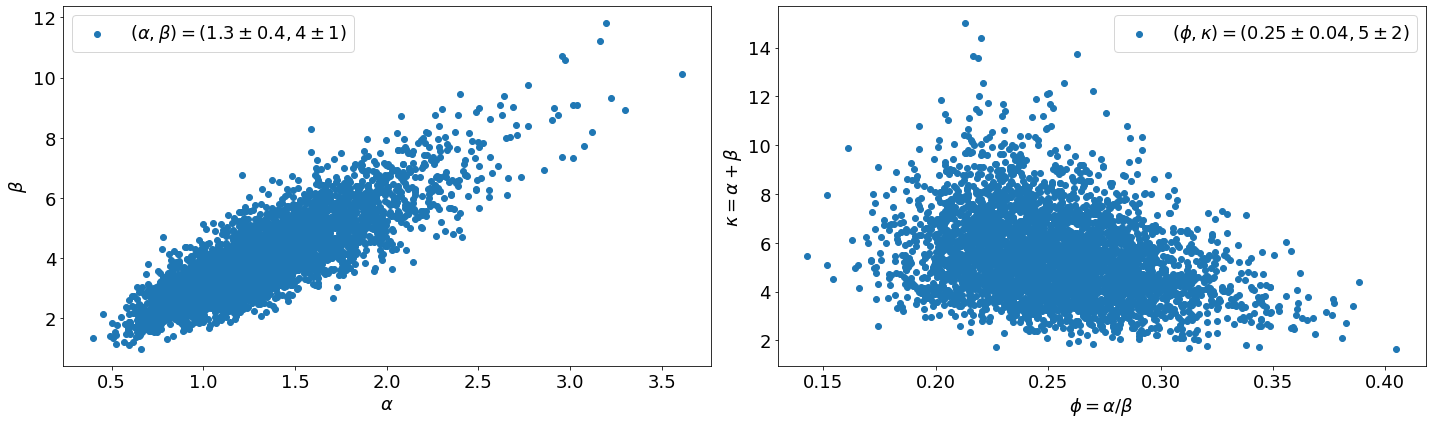

In [42]:
true_post = lambda x: beta.pdf(x,sum(ni)+1,sum(Ni-ni)+1)
x = linspace(0,1,1000)

fig = plt.figure(figsize = (20,6))
plt.subplot(121)
#plot(x,true_post(x),color = "orange", lw = 3,label = "True Post")
ma = mean(hier_samples["alpha"])
sa = std(hier_samples["alpha"])
mb = mean(hier_samples["beta"])
sb = std(hier_samples["beta"])
plt.scatter(hier_samples["alpha"],hier_samples["beta"],label =r"$(\alpha,\beta) = ({:.1f}\pm{:.1f},{:.0f}\pm{:.0f})$".format(ma,sa,mb,sb))
plt.xlabel(r"$\alpha$",fontsize = 18)
plt.ylabel(r"$\beta$",fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize = 18)
#grid()
plt.tight_layout()

subplot(122)

#plot(x,true_post(x),color = "orange", lw = 3,label = "True Post")
mp = mean(hier_samples["phi"])
sp = std(hier_samples["phi"])
mk = mean(hier_samples["kappa"])
sk = std(hier_samples["kappa"])
plt.scatter(hier_samples["phi"],hier_samples["kappa"],label =r"$(\phi,\kappa) = ({:.2f}\pm{:.2f},{:.0f}\pm{:.0f})$".format(mp,sp,mk,sk))
plt.xlabel(r"$\phi = \alpha/ \beta$",fontsize = 18)
plt.ylabel(r"$\kappa = \alpha + \beta $",fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize = 18)
#grid()
plt.tight_layout()


## Posteriors Thetas

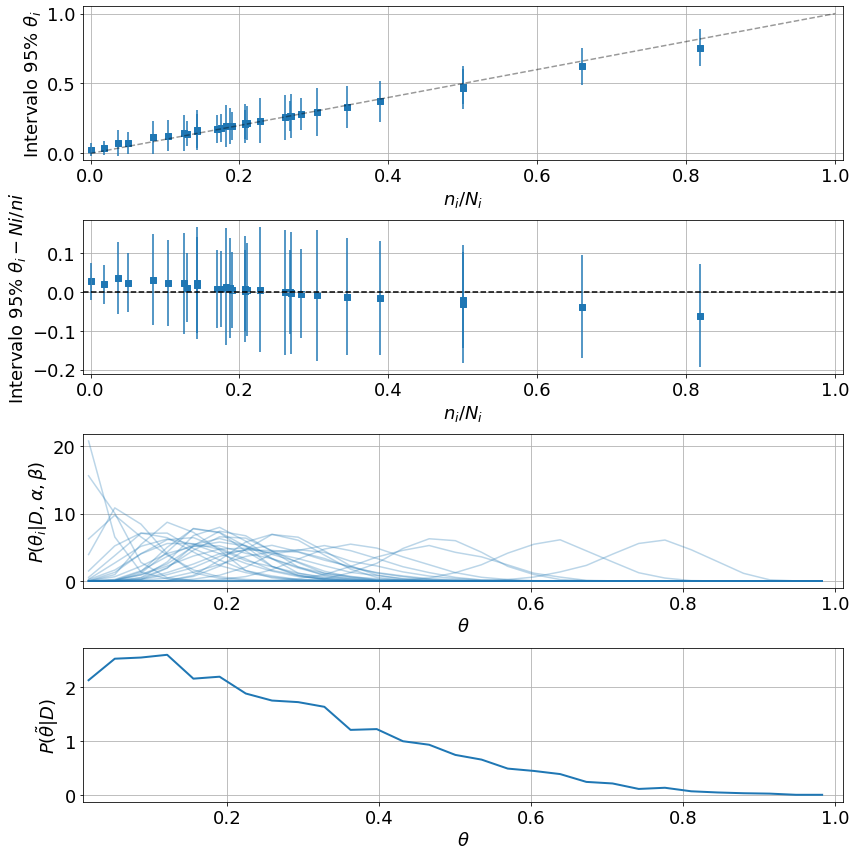

In [51]:
bines = linspace(0,1,30)
xbin = (bines[1:]+bines[:-1])/2
#hti = []
fig = plt.figure(figsize = (12,12))
plt.subplot(413)
for i in range(len(Ni)):
    ti = hier_samples["theta[{}]".format(i+1)]
    hti,_ = histogram(ti,bines,density = True)
    plt.plot(xbin,hti,color = "#1f77b4",alpha = 0.3)
plt.xlim(0.01,1.01)
plt.ylabel(r"$P(\theta_{i}|D,\alpha,\beta)$",fontsize = 18)
plt.xlabel(r"$\theta$",fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.grid()
plt.tight_layout()

plt.subplot(414)
htrep,_ = histogram(hier_samples["theta_rep"],bines,density = True)
plt.plot(xbin,htrep,lw = 2)
plt.xlim(0.01,1.01)
plt.ylabel(r"$P(\tilde{\theta}|D)$",fontsize = 18)
plt.xlabel(r"$\theta$",fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tight_layout()
plt.grid()


plt.subplot(411)

stats_ti = []
for i in range(len(Ni)):
    ti = hier_samples["theta[{}]".format(i+1)]
    stats_ti.append(array([mean(ti),std(ti)]))
stats_ti = array(stats_ti)
plt.errorbar(ni/Ni,stats_ti[::,0],yerr=2*stats_ti[::,1], marker='s',fmt = "none")
plt.scatter(ni/Ni,stats_ti[::,0],marker = "s")
x = linspace(0,1,1000)
plt.plot(x,x,linestyle = "--",color = "k",alpha = 0.4)

plt.ylabel(r"Intervalo 95% $\theta_{i}$",fontsize = 18)
plt.xlabel(r"$n_{i}/N_{i}$",fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tight_layout()

plt.xlim(-0.01,1.01)
plt.ylim(-00.05,)
plt.grid()

plt.subplot(412)

stats_ti = []
for i in range(len(Ni)):
    ti = hier_samples["theta[{}]".format(i+1)]-ni[i]/Ni[i]
    stats_ti.append(array([mean(ti),std(ti)]))
stats_ti = array(stats_ti)
plt.errorbar(ni/Ni,stats_ti[::,0],yerr=2*stats_ti[::,1], marker='s',fmt = "none")
plt.scatter(ni/Ni,stats_ti[::,0],marker = "s")
#x = linspace(0,1,1000)
#plt.plot(x,x,linestyle = "--",color = "k",alpha = 0.4)
plt.axhline(0,color ="k",linestyle ="--")
plt.ylabel(r"Intervalo 95% $\theta_{i} - Ni/ni$",fontsize = 18)
plt.xlabel(r"$n_{i}/N_{i}$",fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tight_layout()

plt.xlim(-0.01,1.01)
#plt.ylim(-00.05,)
plt.grid()

#### Graficar la diferencia respecto a la identidad, para ver mejor el shrinkage.

## Posterior predictivas de los datos

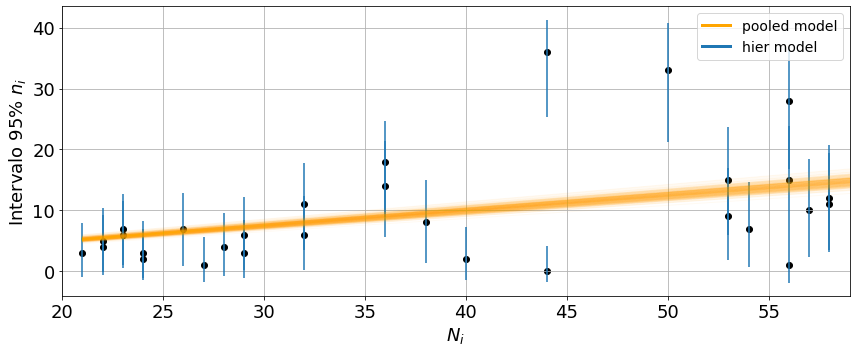

In [53]:

fig = figure(figsize = (12,5))
scatter(Ni,ni,color ="k")
#thetas_pool = beta_dist.rvs(sum(ni)+1,sum(Ni-ni)+1,size = 1000)
x = linspace(min(Ni),60,1000)
for t in betas_samples[::20]:
    plot(x,x*t,color = "orange", lw = 1,alpha = 0.05)
axvline(1000,color = "orange", lw = 3,label = "pooled model")

for i in range(len(Ni)):
    ## pooled
    mean_ni_rep = mean(betas_samples[i])
    std_ni_rep = std(betas_samples[i])
    errorbar(Ni[i],mean_ni_rep,yerr=2*std_ni_rep,fmt = "none",color = "orange")
    
    ###hierar
    mean_ni_rep = mean(hier_samples["ni_rep[{}]".format(i+1)])
    std_ni_rep = std(hier_samples["ni_rep[{}]".format(i+1)])
    errorbar(Ni[i],mean_ni_rep,yerr = 2*std_ni_rep,color ="#1f77b4")
axvline(1000,color ="#1f77b4", lw = 3,label = "hier model")
legend(fontsize = 14)
xlim(min(Ni)-1,max(Ni)+1)

plt.xlabel(r"$N_{i}$",fontsize = 18)
plt.ylabel(r"Intervalo 95% $n_{i}$",fontsize = 18)
tick_params(axis='both', which='major', labelsize=18)
tight_layout()
grid()
    